In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import scipy.stats as stats

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [15]:

# Load the data
ratings_data = pd.read_csv('./ratings.csv')
details_data = pd.read_csv('./details.csv')

# Rename columns in the ratings data for clarity
ratings_data_renamed = ratings_data.rename(columns={
    'rank': 'rating_rank',
    'average': 'rating_average',
    'bayes_average': 'rating_bayes_average',
    'users_rated': 'rating_users_rated'
})

# Merge the datasets on 'id' and 'num'
combined_data = pd.merge(ratings_data_renamed, details_data, on=['id'], suffixes=('_rating', '_details'))

In [16]:

# Drop unnecessary columns
columns_to_drop = ['url', 'thumbnail', 'description', 'boardgamepublisher', 'boardgamedesigner', 'boardgameartist']
cleaned_data = combined_data.drop(columns=columns_to_drop)

# Convert categorical data to numeric format using one-hot encoding
# cleaned_data = pd.get_dummies(cleaned_data, columns=['boardgamecategory', 'boardgamemechanic', 'boardgamefamily', 'boardgameexpansion', 'boardgameimplementation'])
# cleaned_data = cleaned_data.drop(['boardgamecategory', 'boardgamemechanic', 'boardgamefamily', 'boardgameexpansion', 'boardgameimplementation'], axis=1)

# Check for duplicates and drop them
cleaned_data = cleaned_data.drop_duplicates()


cat = cleaned_data.select_dtypes(include=['object'])
#drop categorical because encoding and scaling is troublesome for regression. 
cleaned_data_num = cleaned_data.drop(columns=cat.columns)

In [17]:

#filter on games with more than 250 ratings
popular_cleaned_data_num = cleaned_data_num[cleaned_data_num['rating_users_rated'] > 250]


p-value: 0.9999999999999964
R² score on training data: 0.418389871718044
R² score on test data: 0.46063125842885866
Mean Absolute Error on training data: 2775.2418658241754
Mean Absolute Error on test data: 2842.0855225338832
Mean Squared Error on training data: 46115656.82901234
Mean Squared Error on test data: 39486170.24559888

Model Coefficients:
                      Coefficient
year                   -24.344305
rating_rank            899.023378
rating_average       -2597.012547
rating_bayes_average  7756.832120
yearpublished          -51.489896
minplayers              30.947222
maxplayers             149.603908
playingtime             62.978023
minplaytime             12.044795
maxplaytime              0.031287
minage                -326.366925


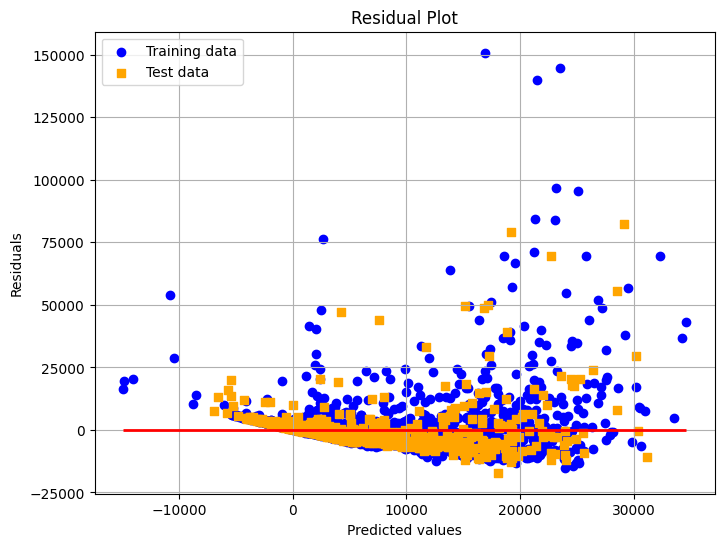

In [20]:

# Prepare data for modeling
X = popular_cleaned_data_num.drop(columns=[
    'id', #because it is not a feature
    'num_rating', #because it is not a feature
    'num_details', #because it is not a feature
    'owned', #because it is the DV
    'wishing', #because it strongly correlated with the DV
    'wanting', #because it strongly correlated with the DV
    'trading', #because it strongly correlated with the DV
    'rating_users_rated', #because it strongly correlated with the DV
    
    ])
y = popular_cleaned_data_num['owned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Train a linear regression model
model = Lasso(alpha=0.5)  # You can adjust the alpha parameter
model.fit(X_train, y_train)


# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
residuals = y_train - y_pred_train
_, p_value = stats.ttest_1samp(residuals, 0)

print("p-value:", p_value)
print(f"R² score on training data: {r2_train}")
print(f"R² score on test data: {r2_test}")
print(f"Mean Absolute Error on training data: {mae_train}")
print(f"Mean Absolute Error on test data: {mae_test}")
print(f"Mean Squared Error on training data: {mse_train}")
print(f"Mean Squared Error on test data: {mse_test}")

# Print model coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print("\nModel Coefficients:")
print(coefficients)

# Plot residuals
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_train, residuals_train, c='blue', marker='o', label='Training data')
plt.scatter(y_pred_test, residuals_test, c='orange', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=min(y_pred_train.min(), y_pred_test.min()), xmax=max(y_pred_train.max(), y_pred_test.max()), color='red', lw=2)
plt.title('Residual Plot')
plt.grid(True)
plt.show()


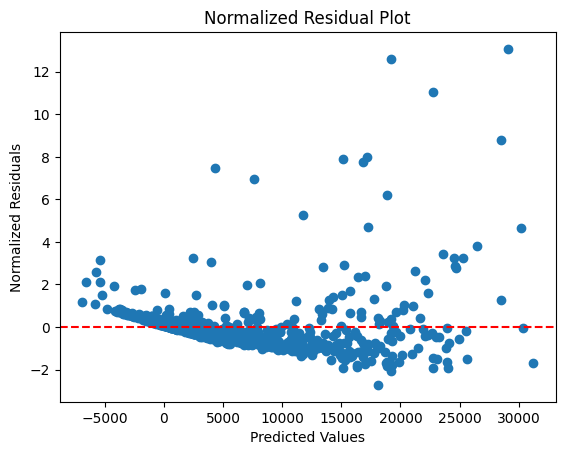

In [25]:

# Calculate the residuals
residuals = y_test - y_pred_test

# Normalize the residuals
normalized_residuals = residuals / np.std(residuals)

# Plot the normalized residuals against the predicted values
plt.scatter(y_pred_test, normalized_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Normalized Residuals')
plt.title('Normalized Residual Plot')
plt.show()

In [ ]:
correlation = cleaned_data_num['year'].corr(cleaned_data_num['yearpublished'])
print(correlation)

0.8741722013208806
